In [1]:
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score,average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def run_metrics(gs_mat, est_mat):
    gs_mat = gs_mat.flatten().astype(int)
    est_mat = est_mat.flatten().astype(int)
    auc_roc = roc_auc_score(gs_mat, est_mat)
    auc_pr = average_precision_score(gs_mat, est_mat)
    print(f"AUCPR {auc_pr}, AUC {auc_roc}")
    return

def analyze(ground_truth, est_graph):
    print(f"Estimated graph has {len(est_graph.edges)} edges compared to ground truth {len(ground_truth.edges)} edges over {len(est_graph.nodes)}")
    run_metrics(nx.adjacency_matrix(ground_truth, ground_truth.nodes()).todense(),
                nx.adjacency_matrix(est_graph, ground_truth.nodes()).todense())
    true_positive = 0
    indirect_pathways_in_est_graph = 0
    est_graph_pathway_ave_length = 0
    est_graph_pathway_intermediates = set()
    for edge in ground_truth.edges:
        if est_graph.has_edge(edge[0], edge[1]):
            true_positive += 1
        elif nx.has_path(est_graph, edge[0], edge[1]):
            path = nx.shortest_path(est_graph, edge[0], edge[1])
            path_length = len(path) - 1
            est_graph_pathway_intermediates.update(set(path[1:path_length]))
            est_graph_pathway_ave_length+=path_length
            indirect_pathways_in_est_graph += 1
    if indirect_pathways_in_est_graph !=0:
        est_graph_pathway_ave_length/=indirect_pathways_in_est_graph

    indirect_pathways_in_ground_truth = 0
    ground_truth_pathway_ave_length = 0
    ground_truth_pathway_intermediates = set()
    evidence = dict()
    for edge in est_graph.edges:
        if edge[0] != 'radiation' and edge[1] != 'radiation':
            if nx.has_path(ground_truth, edge[0], edge[1]) and not ground_truth.has_edge(edge[0], edge[1]):
                path = nx.shortest_path(ground_truth, edge[0], edge[1])
                path_length = len(path) - 1
                ground_truth_pathway_intermediates.update(set(path[1:path_length]))
                ground_truth_pathway_ave_length+=path_length
                indirect_pathways_in_ground_truth += 1
                evidence[edge] = list(path)
    if indirect_pathways_in_ground_truth != 0:
        ground_truth_pathway_ave_length/=indirect_pathways_in_ground_truth
    
    radbio_df = pd.read_csv("./data/prior_knowledge/radiation_edges.txt")
    radbio_net = nx.DiGraph({edge for edge in zip(radbio_df['node1'], radbio_df['node2'])})
    rad_true_positive=0
    for edge in radbio_net.edges:
        if  est_graph.has_edge(edge[0], edge[1]):
            rad_true_positive += 1
    print(f"Estimated graph has {true_positive + rad_true_positive} true positive edges, {rad_true_positive} are in the radiation specific ground truth")
    print(f"Estimated graph contains {indirect_pathways_in_est_graph} indirect pathways A->I->B when ground truth has A->B, \n \
          the average path length is {est_graph_pathway_ave_length} \n and the set of intermediates is {est_graph_pathway_intermediates}")
    print(f"Ground truth graph contains {indirect_pathways_in_ground_truth} indirect pathways A->I->B when estimated graph has A->B, \n \
          the average path length is {ground_truth_pathway_ave_length} \n and the set of intermediates is {ground_truth_pathway_intermediates}")
    sorted_nodes = sorted(est_graph.out_degree(), key=lambda x: x[1], reverse=True)
    print(f"Estimated graph top 5 hubs are {sorted_nodes[0:5]}")
    sorted_nodes = sorted(ground_truth.out_degree(), key=lambda x: x[1], reverse=True)
    print(f"Ground truth graph top 5 hubs are {sorted_nodes[0:5]}")
    if 'radiation' in est_graph.nodes:
        print(f"Estimated graph radiation node has {len(list(nx.neighbors(est_graph, 'radiation')))} neighbors")
    return evidence
    



In [3]:
doses = ["A", "B", "C", "D", "E"]
cd_algs = ["dag_gnn", "genie3"]
        #  "pc_kci_tetrad",
        # "ges_bic_tetrad",
        # "pc_fisherz_tetrad", "genie3"]
for alg in cd_algs:
    for dose in doses:
        print(f"Analyzing dose {dose} with {alg}")
        ground_truth = nx.read_gexf(f"./data/huvec/cd_subgraph_d{dose}.gexf" )
        est_graph = nx.read_gexf(f"./data/huvec/cd_{alg}_d{dose}.gexf" )
        analyze(ground_truth, est_graph)
        print("\n")


Analyzing dose A with dag_gnn
Estimated graph has 926 edges compared to ground truth 1670 edges over 919
AUCPR 0.0020305024023532306, AUC 0.5003005819942866
Estimated graph has 7 true positive edges, 0 are in the radiation specific ground truth
Estimated graph contains 12 indirect pathways A->I->B when ground truth has A->B, 
           the average path length is 2.0 
 and the set of intermediates is {'MAF', 'ICAM1', 'HFE', 'TAPBPL', 'NUPR1', 'DKK3', 'LMO2', 'LATS2'}
Ground truth graph contains 634 indirect pathways A->I->B when estimated graph has A->B, 
           the average path length is 2.165615141955836 
 and the set of intermediates is {'MYC', 'CDKN1A', 'GADD45A', 'PCNA', 'UBB', 'B2M'}
Estimated graph top 5 hubs are [('radiation', 58), ('ADRA1D', 49), ('CDR1', 45), ('MAF', 36), ('KLF4', 25)]
Ground truth graph top 5 hubs are [('MYC', 752), ('CDKN1A', 118), ('B2M', 54), ('GADD45A', 27), ('AR', 4)]
Estimated graph radiation node has 58 neighbors


Analyzing dose B with dag_gnn
Es

KeyboardInterrupt: 

In [14]:
ground_truth = pd.read_csv('./src/GENELink/Code/Demo/hESC/TFs+500/BL--network.csv')
ground_truth = nx.from_edgelist(ground_truth.values.tolist(), create_using=nx.DiGraph)
est_graph = nx.read_gexf(f"./data/BEELINE/cd_dag_gnn.gexf" )
ground_truth_nodes = ground_truth.nodes
est_graph_nodes = est_graph.nodes
ground_truth.add_nodes_from(est_graph_nodes)
est_graph.add_nodes_from(ground_truth_nodes)
analyze(ground_truth, est_graph)

Estimated graph has 1 edges compared to ground truth 4545 edges over 910
AUCPR 0.005488467576379664, AUC 0.4999993928760071
Estimated graph has 0 true positive edges, 0 are in the radiation specific ground truth
Estimated graph contains 0 indirect pathways A->I->B when ground truth has A->B, 
           the average path length is 0 
 and the set of intermediates is set()
Ground truth graph contains 0 indirect pathways A->I->B when estimated graph has A->B, 
           the average path length is 0 
 and the set of intermediates is set()
Estimated graph top 5 hubs are [('ERCC-00130', 1), ('KIF21A', 0), ('DPH2', 0), ('FUS', 0), ('NKX3-1', 0)]
Ground truth graph top 5 hubs are [('TFAP2A', 722), ('JUND', 412), ('NANOG', 346), ('OTX2', 339), ('TEAD4', 320)]


In [ ]:
doses = ["A", "B", "C", "D", "E"]
for d in doses:
    print(f"Analyzing dose {d}")
    y_pred = pd.read_csv(f"./data/huvec/GENELink_data_files/Result_{d}/pred.csv", header=0)
    y_true = pd.read_csv(f"./data/huvec/GENELink_data_files/Test_set_{d}.csv", header=0)
    gene_names = pd.read_csv(f"./data/huvec/GENELink_data_files/Target_{d}.csv")
    precision, recall, thresholds = precision_recall_curve(y_true.values[:,-1], y_pred.values[:,-1])
    #plt.plot(precision, recall, label=d)
    #plt.legend()
    opt_threshold = thresholds[0]
    opt_score = -1
    for t in thresholds:
        score = f1_score(y_true.values[:,-1], np.array(y_pred.values[:,-1] >= t, dtype=int))
        if score > opt_score:
            opt_score = score
            opt_threshold = t
    print(f"F1 score {opt_score}, threshold {opt_threshold}")
    ground_truth_edges = []
    for _,y in y_true.iterrows():
        if y["Label"] == 1:
            tf = gene_names.loc[gene_names["index"]==y["TF"]]["Gene"].iloc[0]
            gene = gene_names.loc[gene_names["index"]==y["Target"]]["Gene"].iloc[0]
            ground_truth_edges.append((tf, gene ))
    pred_edges = []
    for _,y in y_pred.iterrows():
        if y["Label"] >= opt_threshold:
            tf = gene_names.loc[gene_names["index"]==y["TF"]]["Gene"].iloc[0]
            gene = gene_names.loc[gene_names["index"]==y["Target"]]["Gene"].iloc[0]
            pred_edges.append((tf, gene, y["Label"]))
    ground_truth_graph = nx.from_edgelist(ground_truth_edges, create_using=nx.DiGraph)
    pred_graph =  nx.DiGraph()
    pred_graph.add_weighted_edges_from(pred_edges)
    pred_graph.add_nodes_from(ground_truth_graph.nodes)
    nx.write_gexf(pred_graph, f'./data/huvec/GENELink_data_files/Result_{d}/pred_graph.gexf')
    
    ground_truth_nodes = ground_truth_graph.nodes
    pred_graph_nodes = pred_graph.nodes
    ground_truth_graph.add_nodes_from(pred_graph_nodes)
    pred_graph.add_nodes_from(ground_truth_nodes)
    analyze(ground_truth_graph, pred_graph)

Analyzing dose A
F1 score 0.43089430894308944, threshold 0.0001773330877767
Estimated graph has 1152 edges compared to ground truth 570 edges over 614
AUCPR 0.0015119523814576283, AUC 0.5
Estimated graph has 371 true positive edges, 0 are in the radiation specific ground truth
Estimated graph contains 37 indirect pathways A->I->B when ground truth has A->B, 
           the average path length is 3.72972972972973 
 and the set of intermediates is {'UPF1', 'GADD45A', 'UBB', 'CDKN1A', 'SENP2', 'B2M'}
Ground truth graph contains 342 indirect pathways A->I->B when estimated graph has A->B, 
           the average path length is 3.017543859649123 
 and the set of intermediates is {'CCNB1', 'GADD45A', 'MDM2', 'UBB', 'MYC', 'CDKN1A', 'AR', 'PIK3R1', 'HSP90AA1', 'CDT1', 'B2M', 'PDIA3'}
Estimated graph top 5 hubs are [('CDKN1A', 212), ('MYC', 128), ('ELF1', 47), ('PPARA', 19), ('CDCA7L', 18)]
Ground truth graph top 5 hubs are [('MYC', 173), ('CDKN1A', 28), ('B2M', 13), ('GADD45A', 7), ('HNRNPK',

In [4]:
def get_TF_targets(graph, top_n, method, dose):
    values = []
    sorted_nodes = sorted(graph.out_degree(), key=lambda x: x[1], reverse=True) #[0:top_n]
    for TF,_ in sorted_nodes:
        if TF == 'radiation':
            continue
        targets = list(nx.neighbors(graph, TF))
        for target in targets:
            weight = graph.get_edge_data(TF, target)["weight"]
            values.append([TF, target, method, dose, weight])
    df = pd.DataFrame(data=values)
    df.columns=["TF", "target", "method", "dose rate", "weight"]
    return df
    
def get_overlapping_edges(graphs):
    common_edges = set(graphs[0].edges())
    for g in graphs[1:]:
        common_edges = common_edges.intersection(set(g.edges()))
    print(len(common_edges), common_edges)
    return common_edges
    
save_dfs = []
doses = ["A", "B", "C", "D", "E"]
overlapping_by_dose = []
for d in doses:
    est_graph_gnn = nx.read_gexf(f"./data/huvec/cd_dag_gnn_d{d}.gexf" )
    est_graph_genie = nx.read_gexf(f"./data/huvec/cd_genie3_d{d}.gexf")
    est_graph_genelink = nx.read_gexf(f'./data/huvec/GENELink_data_files/Result_{d}/pred_graph.gexf')
    df_dag_gnn = get_TF_targets(est_graph_gnn, 5, "dag_gnn", d)
    df_genie = get_TF_targets(est_graph_genie, 5, "genie3", d)
    df_genelink = get_TF_targets(est_graph_genelink, 5, "GENELink", d)
    save_dfs.append(df_dag_gnn)
    save_dfs.append(df_genie)
    save_dfs.append(df_genelink)
    ov = get_overlapping_edges([est_graph_gnn, est_graph_genie, est_graph_genelink])
    overlapping_by_dose.append(ov)
df_final = pd.concat(save_dfs)
#df_final.to_csv("./data/huvec/est_tf_target_all.csv", index=False, header=True)




6 {('B2M', 'SEC23A'), ('MAF', 'B2M'), ('ADRA1D', 'B2M'), ('LATS2', 'CDKN1A'), ('B2M', 'DKK3'), ('HFE', 'B2M')}


KeyboardInterrupt: 

In [8]:
df_final['weight'] = np.abs(df_final['weight'])
df_final_sorted = df_final.sort_values(by='weight', ascending=False)
df_final_sorted.reset_index(inplace=True)
print(df_final_sorted)

           index      TF     target   method dose rate        weight
0            505  BCL2A1      THBS1  dag_gnn         C  5.168354e+02
1            529  BCL2A1      THBS1  dag_gnn         B  3.270375e+02
2             45   FOXS1     EEF1A1  dag_gnn         C  3.060399e+02
3            326   CRYAB       MMP1  dag_gnn         C  1.673660e+02
4            188    EGR2      THBS1  dag_gnn         C  1.427584e+02
...          ...     ...        ...      ...       ...           ...
6673281  1775313  DPYSL3  radiation   genie3         D  3.416071e-20
6673282  1770714   LAMC1  radiation   genie3         D  3.416071e-20
6673283  1274768   NCOA2  radiation   genie3         D  3.416071e-20
6673284   465533    RPS8  radiation   genie3         D  3.416071e-20
6673285   391751   KLF16      ESRP2   genie3         C  1.708035e-20

[6673286 rows x 6 columns]


In [ ]:
consensus_ranks_genie = []
consensus_ranks_gnn = []
consensus_ranks_genelink = []
for d, ov in zip(doses, overlapping_by_dose):
    for edge in ov:
        df_genie_subset = df_final_sorted[(df_final_sorted['method']=='genie3') & (df_final_sorted['dose rate']==d)]
        df_gnn_subset = df_final_sorted[(df_final_sorted['method']=='dag_gnn')& (df_final_sorted['dose rate']==d)]
        df_genelink_subset = df_final_sorted[(df_final_sorted['method']=='GENELink')& (df_final_sorted['dose rate']==d)]
        df_genie_subset.reset_index(inplace=True)
        df_gnn_subset.reset_index(inplace=True)
        df_genelink_subset.reset_index(inplace=True)

        rank_genie = df_genie_subset[(df_genie_subset['TF'] == edge[0]) & (df_genie_subset['target'] == edge[1])].index
        rank_gnn = df_gnn_subset[(df_gnn_subset['TF'] == edge[0]) & (df_gnn_subset['target'] == edge[1])].index
        rank_genelink = df_genelink_subset[(df_genelink_subset['TF'] == edge[0]) & (df_genelink_subset['target'] == edge[1])].index
        consensus_ranks_genie.append(rank_genie.values[0]/len(df_genie_subset))
        consensus_ranks_gnn.append(rank_gnn.values[0]/len(df_gnn_subset))
        consensus_ranks_genelink.append(rank_genelink.values[0]/len(df_genelink_subset))


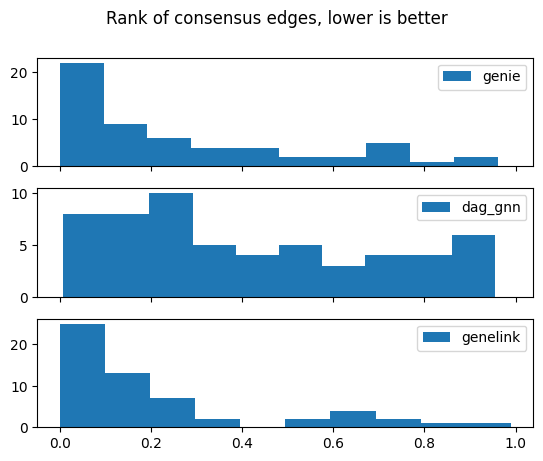

In [32]:
(fig, axs) = plt.subplots(3,1, sharex=True)
fig.suptitle("Rank of consensus edges, lower is better")
axs[0].hist(consensus_ranks_genie, label='genie')
axs[1].hist(consensus_ranks_gnn, label='dag_gnn')
axs[2].hist(consensus_ranks_genelink, label='genelink')
axs[0].legend()
axs[1].legend()
axs[2].legend()


In [18]:
edges= []
for d, ov in zip(doses, overlapping_by_dose):
    for tf, gene in ov:
        edges.append([tf, gene, d])
df_consensus = pd.DataFrame(edges)
df_consensus.columns = ["TF", "target", "dose"]
df_consensus.to_csv("./data/huvec/consensus_edges.csv", index=False)

In [ ]:
df_consensus = pd.read_csv("./data/huvec/consensus_edges.csv", header=0)
evidence = dict()
for d in doses: 
    print(f"Analyzing dose {d}...")
    ground_truth = nx.read_gexf(f"./data/huvec/cd_subgraph_d{d}.gexf" )
    consensus_graph = nx.from_pandas_edgelist(df_consensus[df_consensus["dose"]==d], source="TF", target="target", create_using=nx.DiGraph)
    
    ground_truth_nodes = ground_truth.nodes
    pred_graph_nodes = consensus_graph.nodes
    ground_truth.add_nodes_from(pred_graph_nodes)
    consensus_graph.add_nodes_from(ground_truth_nodes)
    
    evidence_by_dose = analyze(ground_truth, consensus_graph)
    print(evidence_by_dose)
    evidence.update(evidence_by_dose)
    print()
evidence_ordered=[]
for _,row in df_consensus.iterrows():
    edge = (row.loc["TF"], row.loc["target"])
    if edge in evidence.keys():
        e = evidence[edge]
        evidence_ordered.append(str(e))
    else:
        evidence_ordered.append("true positive")
df_consensus['evidence'] = evidence_ordered

Analyzing dose A...
Estimated graph has 6 edges compared to ground truth 1670 edges over 918
AUCPR 0.005567363571232803, AUC 0.5017964071856288
Estimated graph has 6 true positive edges, 0 are in the radiation specific ground truth
Estimated graph contains 0 indirect pathways A->I->B when ground truth has A->B, 
           the average path length is 0 
 and the set of intermediates is set()
Ground truth graph contains 0 indirect pathways A->I->B when estimated graph has A->B, 
           the average path length is 0 
 and the set of intermediates is set()
Estimated graph top 5 hubs are [('B2M', 2), ('MAF', 1), ('ADRA1D', 1), ('LATS2', 1), ('HFE', 1)]
Ground truth graph top 5 hubs are [('MYC', 752), ('CDKN1A', 118), ('B2M', 54), ('GADD45A', 27), ('AR', 4)]
{}

Analyzing dose B...
Estimated graph has 0 edges compared to ground truth 3729 edges over 1590
AUCPR 0.0014750207665836003, AUC 0.5
Estimated graph has 0 true positive edges, 0 are in the radiation specific ground truth
Estimated g

In [16]:
df_consensus.to_csv("./data/huvec/consensus_edges_w_indirect_evidence.csv", index=False)

In [ ]:
ground_truth = nx.read_gexf(f"./data/huvec/cd_subgraph_dC.gexf" )
est_dag = nx.read_gexf(f"./data/huvec/cd_dag_gnn_dC.gexf")
est_dag = nx.read_gexf(f"./data/huvec/GENELink_data_files/Result_C/pred_graph.gexf")
# shortest_path = nx.shortest_path(ground_truth, "EGR2", "BTG2"
# print(len(ground_truth.edges()), shortest_path)
for path in nx.all_simple_paths(ground_truth, source="EGR2", target="BTG2", cutoff=10):
    print(path)
# for path in nx.all_simple_paths(ground_truth, source="EGR2", target="BTG2", cutoff=3):
#     print(path)